<a href="https://colab.research.google.com/github/emma250/ML-in-Finance/blob/main/PortfolioAllocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porfolio Allocation in BL, Kelly and Leveraging.

In [ ]:
# packages used to get the data and analysis
!pip install yfinance --quiet
!pip install PyPortfolioOpt --quiet

     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 61 kB 5.2 MB/s 


Cloning private github repo<br>
This repo was created by our group to avoid intense upload of private library for each runtime

In [ ]:
# Cloning private github repo
! git clone https://github.com/emma250/Library_Kelly --quiet
%cd Library_Kelly

/content/Library_Kelly


In [ ]:
from util import (
    get_kelly, filter_leverage, get_cumulative_returns, backtest
)

In [ ]:
#Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. a, b select stocks and download the data

In [ ]:
# Set the start and end date
start_date = '2021-01-01'
end_date = '2021-08-08'

# Define the ticker list
tickers_list = ['AAPL', 'IBM', 'MSFT', 'BABA','TSLA']

# Create placeholder for data
stock = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    stock[ticker] = yf.download(ticker, 
                               start_date,
                               end_date)['Adj Close']
    
# Print stock info
print(stock)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  AAPL         IBM        MSFT        BABA        TSLA
Date                                                                  
2021-01-04  128.087082  108.764389  214.934357  227.850006  729.770020
2021-01-05  129.670685  110.695000  215.141708  240.399994  735.109985
2021-01-06  125.305809  113.459312  209.563187  227.610001  755.979980
2021-01-07  129.581619  113.196037  215.526764  226.899994  816.039978
2021-01-08  130.700089  112.792366  216.839920  236.190002  880.020020
...                ...         ...         ...         ...         ...
2021-08-02  144.492630  127.167625  282.513123  200.089996  709.669983
2021-08-03  146.

## 1.c Covariance matrix calculation

In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(stock)
S = CovarianceShrinkage(stock).ledoit_wolf()

In [ ]:
print('The covariance matrix is \n', S)

The covariance matrix is 
           AAPL       IBM      MSFT      BABA      TSLA
AAPL  0.074807  0.001001  0.035501  0.022371  0.071661
IBM   0.001001  0.063007 -0.000324 -0.003931 -0.005070
MSFT  0.035501 -0.000324  0.051199  0.021040  0.050579
BABA  0.022371 -0.003931  0.021040  0.134988  0.064782
TSLA  0.071661 -0.005070  0.050579  0.064782  0.305836


## 1. d Classical Markowitz portfolio optimization

In [ ]:
from pypfopt import EfficientFrontier, objective_functions
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg)
weights = ef.max_sharpe()

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


In [ ]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print('The weights of the 5 stocks should be',cleaned_weights)

The weights of the 5 stocks should be OrderedDict([('AAPL', 0.17241), ('IBM', 0.28669), ('MSFT', 0.5409), ('BABA', 0.0), ('TSLA', 0.0)])


In [ ]:
# Expected return
ef.portfolio_performance(verbose=True)

Expected annual return: 48.2%
Annual volatility: 17.0%
Sharpe Ratio: 2.71


(0.4815730251887843, 0.17029902609353237, 2.7103679673146055)

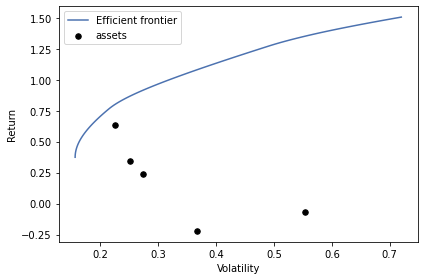

In [ ]:
import matplotlib.pyplot as plt
from pypfopt import plotting
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

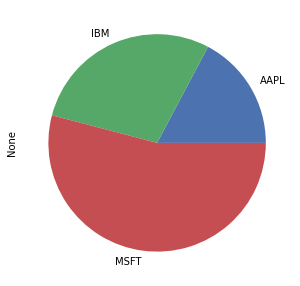

In [ ]:
# chart of the weights. 
pd.Series(weights).plot.pie(figsize=(5,5));

#2 **Jiawei Zhang** addresses Black-Litterman.

## 2.1 quantitative translatation

In [ ]:
# Download S&P500 as the market price
market_prices = yf.download("SPY", start_date, end_date)["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2021-01-04    361.251129
2021-01-05    363.739227
2021-01-06    365.913818
2021-01-07    371.350372
2021-01-08    373.466278
Name: Adj Close, dtype: float64

In [ ]:
mcaps = {}
for t in tickers_list:
    s = yf.Ticker(t)
    mcaps[t] = s.info["marketCap"]
mcaps

{'AAPL': 2781023043584,
 'BABA': 249477693440,
 'IBM': 120821424128,
 'MSFT': 2181059969024,
 'TSLA': 969641885696}

## 2.b Black-Litterman model
### Priors construction

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(stock).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
print(delta)

18.420619878414865


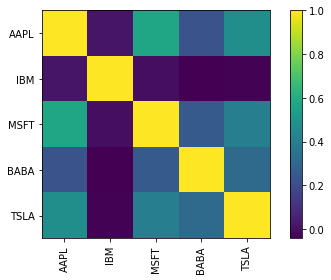

In [ ]:
#Plot covariance of 5 stocks
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print(market_prior)

AAPL    1.074194
IBM     0.031089
MSFT    0.793570
BABA    0.616640
TSLA    1.837232
dtype: float64


### Views. Here the absolute views are provided

In [ ]:
viewdict = {"AAPL": 0.20, "IBM": -0.30, "MSFT": 0.11, "BABA": -0.5, "TSLA": 0.3}
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### View confidences

In [ ]:
# we calculated the uncertainty matrix by specifying 1 standard deviation confidence intervals, which the true return is 68% 
intervals = [(0, 0.25),(0.1, 0.4), (-0.1, 0.15),(0.1, 0.9),(0, 0.3)]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.16000000000000003, 0.0225]


### Posterior estimates

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
print(ret_bl)

AAPL    0.743673
IBM    -0.019609
MSFT    0.547124
BABA    0.381519
TSLA    1.078218
dtype: float64


In [ ]:
# Check the value of prior and posterior
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
print(rets_df)

         Prior  Posterior  Views
AAPL  1.074194   0.743673   0.20
IBM   0.031089  -0.019609  -0.30
MSFT  0.793570   0.547124   0.11
BABA  0.616640   0.381519  -0.50
TSLA  1.837232   1.078218   0.30


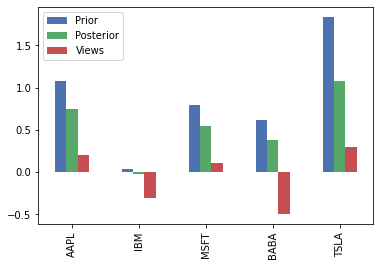

In [ ]:
#Visulization
rets_df.plot.bar(figsize=(6,4));

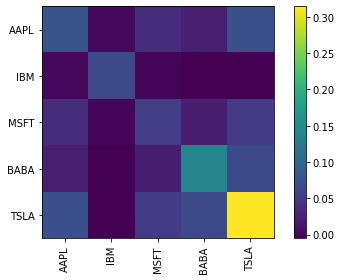

In [ ]:
# posterior covariance estimate:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

### BL Portfolio allocation

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AAPL', 0.2955),
             ('IBM', 0.0),
             ('MSFT', 0.21539),
             ('BABA', 0.12451),
             ('TSLA', 0.36461)])

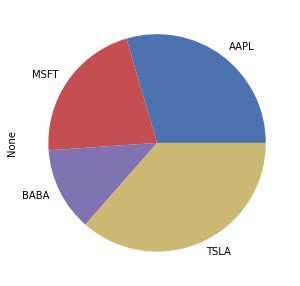

In [ ]:
pd.Series(weights).plot.pie(figsize=(5,5));

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 77.8%
Annual volatility: 30.1%
Sharpe Ratio: 2.52


(0.7782252323161841, 0.30118897572806885, 2.517440190110924)

# 3. **Emmanuel Muragijimana** addresses Kelly criterion.

`Within this topic, the Kelly Criterion is going to be our tool to control leverage of, and allocation towards, a set of 5 securities that make up a multi-strategy portfolio.`

## Part 1. Kelly Criterion to size alloction of each security using **6 months daily returns**

### 3.a. Back-testing using the Kelly criterion for 5 Securities

In [ ]:
# Return of our given securities
stock= stock
returns_df = stock.pct_change()
shift_returns = returns_df.shift(-1)

In [ ]:
returns_df.corr()

,AAPL,IBM,MSFT,BABA,TSLA
AAPL,1.000000,0.017751,0.718409,0.255139,0.528510
IBM,0.017751,1.000000,-0.007280,-0.049766,-0.041504
MSFT,0.718409,-0.007280,1.000000,0.304028,0.472626
BABA,0.255139,-0.049766,0.304028,1.000000,0.341166
TSLA,0.528510,-0.041504,0.472626,0.341166,1.000000


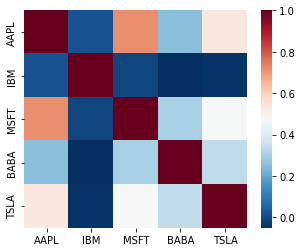

In [ ]:
# Visualization of Correlation of the returns on heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(returns_df.corr(), cmap="RdBu_r")

In [ ]:
# f* values for correlated securities
opt_correlated_kelly = get_kelly(returns_df, correlation=True)

# f* values for uncorrelated securities
opt_uncorrelated_kelly = get_kelly(returns_df, correlation=False)

# set parameters for the backtest
leverages = range(1, 6) # Leverage_1 much stronger, Leverage_5 much weaker
start_date = opt_correlated_kelly.index[0]
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly, shift_returns, leverages)

In [ ]:
total_returns_corr.head()

,max_leverage_1,max_leverage_2,max_leverage_3,max_leverage_4,max_leverage_5
Date,,,,,
2021-01-19,0.030727,0.061455,0.092182,0.122909,0.153637
2021-01-20,-0.000412,-0.000823,-0.001235,-0.001647,-0.002058
2021-01-21,-0.069009,-0.138017,-0.207026,-0.276034,-0.345043
2021-01-22,0.024964,0.049928,0.074892,0.099856,0.124820
2021-01-25,0.006152,0.012304,0.018455,0.024607,0.030759


In [ ]:
securities = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / securities
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

In [ ]:
cum_returns_corr.head()

,max_leverage_1,max_leverage_2,max_leverage_3,max_leverage_4,max_leverage_5,reinvest_equally_weight,invest_once_equally_weight
Date,,,,,,,
2021-01-19,1.030727,1.061455,1.092182,1.122909,1.153637,1.027911,1.027911
2021-01-20,1.030303,1.060581,1.090833,1.121060,1.151262,1.032935,1.032843
2021-01-21,0.959203,0.914202,0.865003,0.811609,0.754027,1.016000,1.016271
2021-01-22,0.983149,0.959847,0.929785,0.892653,0.848145,1.035160,1.035839
2021-01-25,0.989197,0.971656,0.946944,0.914619,0.874233,1.048994,1.049013


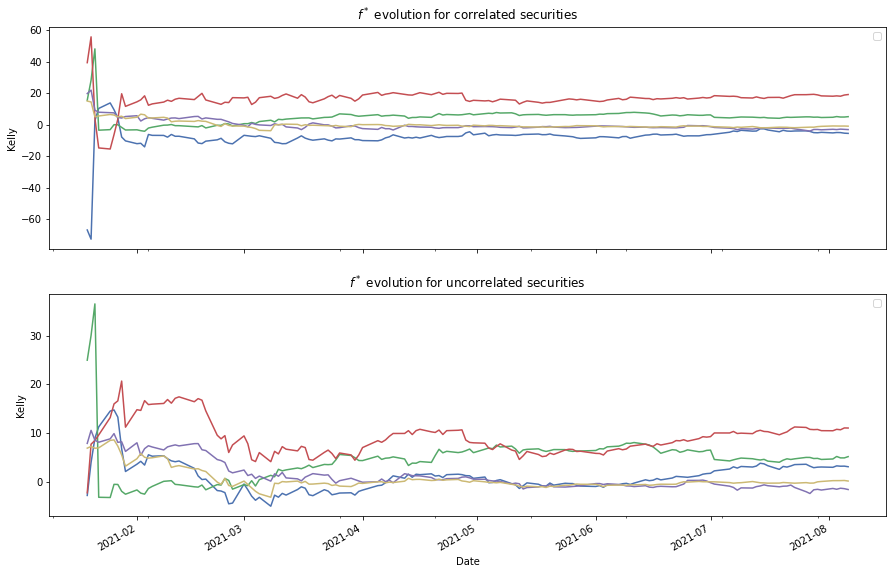

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

opt_correlated_kelly.plot(ax=ax[0])
ax[0].set_title('$f^*$ evolution for correlated securities');
ax[0].set_ylabel('Kelly');
ax[0].legend([]);

opt_uncorrelated_kelly.plot(ax=ax[1])
ax[1].set_title('$f^*$ evolution for uncorrelated securities');
ax[1].set_ylabel('Kelly');
ax[1].legend([]);

### 3.b. Series of historical backtests with leverage up to 5


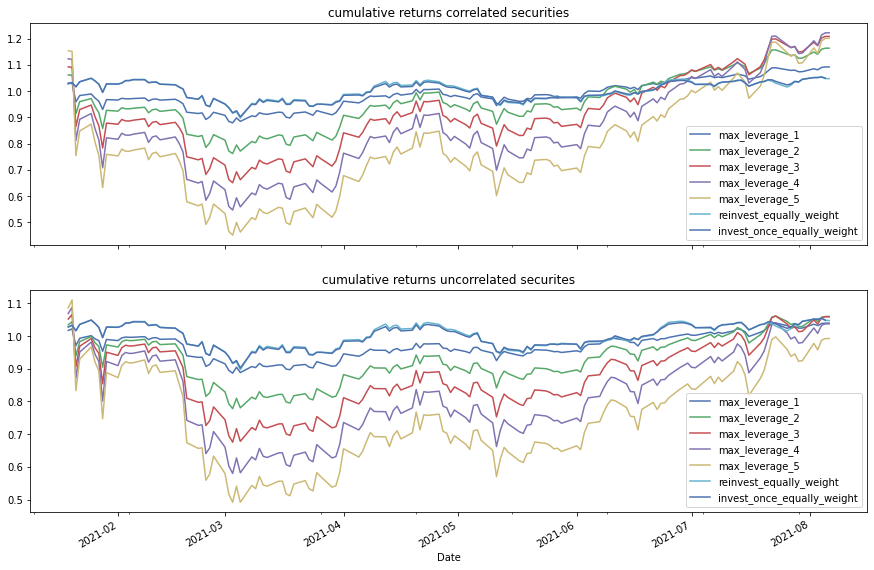

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('cumulative returns correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('cumulative returns uncorrelated securites');

In [ ]:
#@title
from IPython.display import Image
Image(url='https://myoctocat.com/assets/images/base-octocat.svg', width=100)

## Part 2. Kelly Criterion to size alloction of each security using **2 Years daily returns**

####**NB:** While the interpretation of the cumulative of the returns of the securities of Kelly Criterion on a series of 6 month historical backtests to see how the combined portfolio performs does not clearly visualise the difference of 5 the leverages. Let's redo the process, but this time with 2 years of historical backtests.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


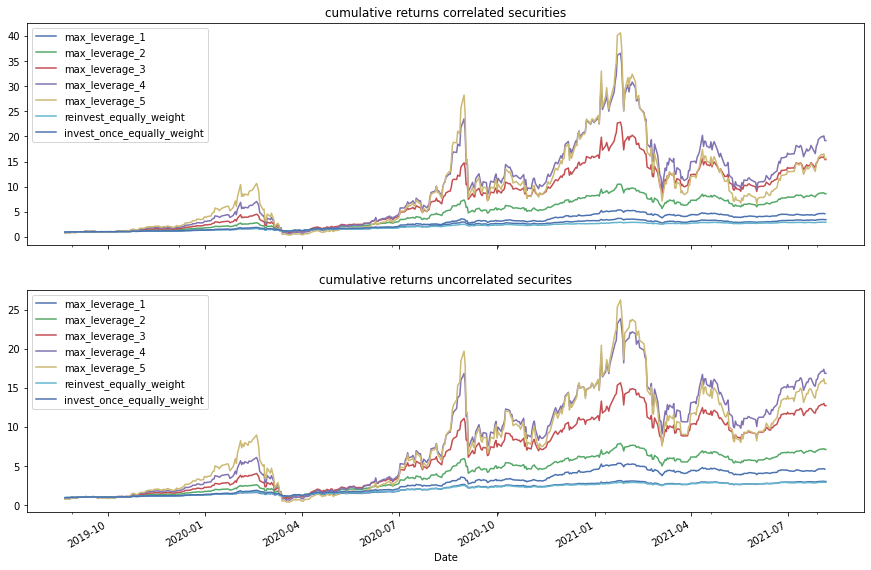

In [ ]:
# Set the start and end date
start_date = '2019-08-08'
end_date = '2021-08-08' # 2 years data instead of 6months

# Define the ticker list
tickers_list = ['AAPL', 'IBM', 'MSFT', 'BABA','TSLA']

# Create placeholder for data
stock = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    stock[ticker] = yf.download(ticker, 
                               start_date,
                               end_date)['Adj Close']
    
# Print stock info

stock= stock
returns_df = stock.pct_change()
shift_returns = returns_df.shift(-1)

# f* values for correlated securities
opt_correlated_kelly = get_kelly(returns_df, correlation=True)

# f* values for uncorrelated securities
opt_uncorrelated_kelly = get_kelly(returns_df, correlation=False)

# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly.index[0]
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly, shift_returns, leverages)

securities = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / securities
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('cumulative returns correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('cumulative returns uncorrelated securites');


##`Based on these cumulative returns, 6 months of historical data were insufficient to demonstrate the strength and applicability of the Kelly Criterion for portfolio allocation. Using Kelly Criterion, Backtesting enough data results in accurate and coherent decisions`

## 4. **Raymond Yaw Normeshie** addresses leverage constraints applied to the previous portfolio.

#### In this Section we:
#### a) Apply a leverage constraint smaller than Kelly (such as half-Kelly)
#### b) Apply a leverage constraint larger than Kelly (such as two to five times Kelly) to our Portfolio of securities used above:

It is frequently commented that a big problem with Kelly is that bankroll growth will be erratic, with profits interrupted by sometimes significant losses. In other words, the evolution of the bankroll is volatile.

As explained by Emmanuel Muragijimana in previous section, the Kelly stake size is calculated $(edge – 1 / odds – 1)$ , sudden and large drawdowns will arise where a short price bet, which we believe holds significant positive expectation, loses.

In this implementation, I'll follow the lead of Emmanuel Muragijimana because it's proven that backtesting data less than one year time doesn't provide better visual graphs. Here, let's take 2 years time.

### a) Half-Kelly Criterion:

Fractional Kelly appears to offer the bettor a solution to the volatility risks associated with full Kelly without giving up too much of the advantage that the Kelly strategy offers over fixed staking. For those averse to large losses, that will hopefully come as welcome news.

Of course, as always, the much tougher battle is to be sure you hold the advantage over the odds; believing and knowing that you do is not the same thing.

In [ ]:
# Set the start and end date
start_date = '2019-01-01'
end_date = '2021-08-08'

# Define the ticker list
tickers_list = ['AAPL', 'IBM', 'MSFT', 'BABA','TSLA']

# Create placeholder for data
stock = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    stock[ticker] = yf.download(ticker, 
                               start_date,
                               end_date)['Adj Close']
    
# Print stock info
print(stock)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  AAPL         IBM        MSFT        BABA        TSLA
Date                                                                  
2019-01-02   38.168346   91.668594   97.353912  136.699997   62.023998
2019-01-03   34.366497   89.838577   93.772453  130.600006   60.071999
2019-01-04   35.833584   93.347466   98.133728  139.750000   63.537998
2019-01-07   35.753830   94.007858   98.258888  143.100006   66.991997
2019-01-08   36.435402   95.344566   98.971352  146.789993   67.070000
...                ...         ...         ...         ...         ...
2021-08-02  144.492630  127.167610  282.513123  200.089996  709.669983
2021-08-03  146.

In [ ]:
stock= stock
returns_df = stock.pct_change()
shift_returns = returns_df.shift(-1)

# f* values for correlated securities
opt_correlated_kelly_half = get_kelly(returns_df, correlation=True)/2

# f* values for uncorrelated securities
opt_uncorrelated_kelly_half = get_kelly(returns_df, correlation=False)/2

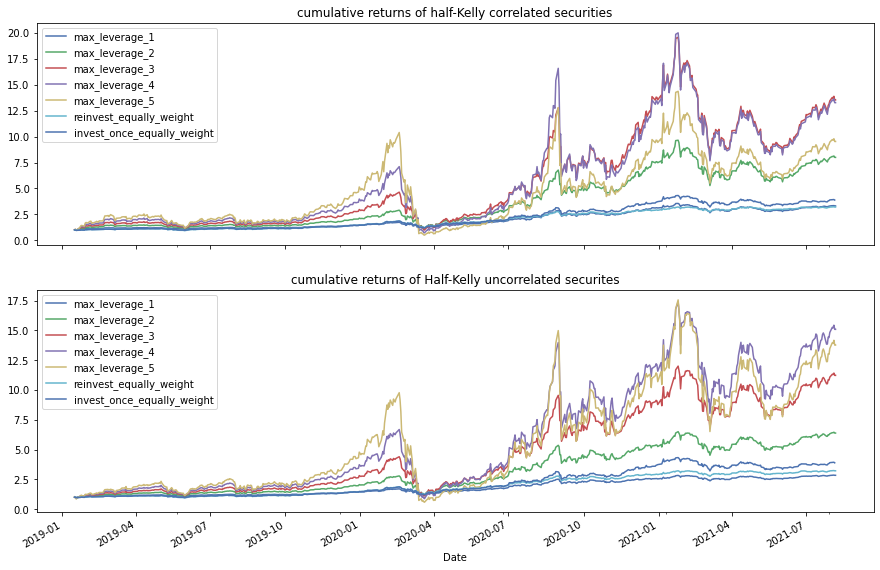

In [ ]:
# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly_half.index[0]
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly_half, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly_half, shift_returns, leverages)

securities = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / securities
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('cumulative returns of half-Kelly correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('cumulative returns of Half-Kelly uncorrelated securites');

### b) Double-Kelly Criterion:

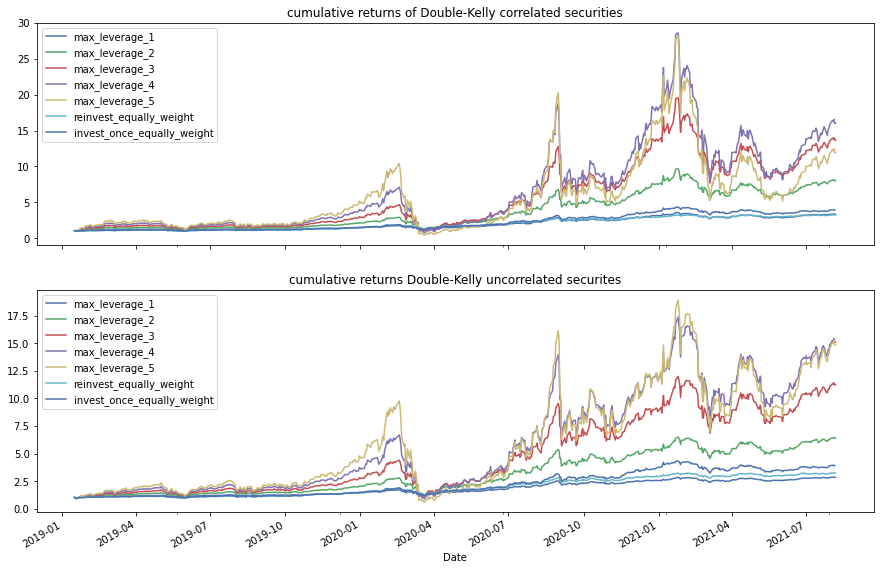

In [ ]:
# f* values for correlated securities
opt_correlated_kelly_double = get_kelly(returns_df, correlation=True)*2

# f* values for uncorrelated securities
opt_uncorrelated_kelly_double = get_kelly(returns_df, correlation=False)*2

# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly_double.index[0]
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly_double, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly_double, shift_returns, leverages)

securities = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / securities
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / securities

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('cumulative returns of Double-Kelly correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('cumulative returns Double-Kelly uncorrelated securites');
